In [2]:
from model import *
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.spatial.distance import jaccard
import albumentations as A
#device = torch.device('cpu')
device = torch.device('cuda:1')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
#Dataset Params
paths = ["/data/spacenet/AOI_1_Rio","/data/spacenet/AOI_2_Vegas","/data/spacenet/AOI_3_Paris","/data/spacenet/AOI_4_Shanghai","/data/spacenet/AOI_5_Khartoum","/data/crowdai"]
img_dir = "3band"
mask_dir = "masks"
batch_size_val = 4
img_size = 256
zero_prop = 1.0 #Drop any images that are more than x percent 0 values.
#Weight map parameters
constant = 200
transform = A.Compose([
            A.CropNonEmptyMaskIfExists(width=img_size, height=img_size),
            ])

val = BetaNetDataset(device, paths, img_dir, mask_dir, train_val="val", 
img_size = img_size, batch_size = batch_size_val, zero_prop = zero_prop, transform = transform,
constant=constant, lam=0)

In [46]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
model_path = "./model_save/openbldg/model_unetresnet50_ce_1perprop_200tdiv_65perthresh_uniary14 Mar 2023 15:18_4_0.1632"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [47]:
x, y = val.gen_batch()
y_hat = model(x)

In [48]:
sigmoidOutput = torch.sigmoid(y_hat)
thresholdOutput = (sigmoidOutput > 0.65).detach().cpu().numpy()
thresholdOutput.shape

(4, 1, 256, 256)

In [171]:
def get_furthest_point_from_edge(poly_mask):
    from scipy.ndimage.morphology import distance_transform_edt
    d = distance_transform_edt(poly_mask)
    cy, cx = np.unravel_index(d.argmax(), d.shape)
    return cx, cy

def find_poly(pred):
    import skimage as ski
    import numpy as np
        
    pred_con = np.zeros(pred.shape)
    
    padded_pred = np.pad(pred, pad_width=1, mode='constant', constant_values=0)
    contours = ski.measure.find_contours(padded_pred, 0.5)
    for contour in contours:
        for point in contour:
            point[0] -= 1
            point[1] -= 1
            if point[0] < 0:
                point[0] = 0
            if point[1] < 0:
                point[0] = 0
        if not np.array_equal(contour[0], contour[-1]):
            contour = np.vstack((contour, contour[0]))
        
        poly = ski.measure.approximate_polygon(contour, tolerance=2.5)

        rr, cc = ski.draw.polygon(poly[:,0], poly[:,1], pred.shape)
        pred_con[rr, cc] = 1
        
        pred_center = np.zeros_like(pred)
        pred_center[rr, cc] = 1
        center = get_furthest_point_from_edge(pred_center)

        rr, cc = ski.draw.circle_perimeter(center[1], center[0], 5)
        rr = rr.clip(0, 255)
        cc = cc.clip(0, 255)
        pred_con[rr, cc] = 2

    return pred_con




In [172]:
pred_con = np.zeros(thresholdOutput.squeeze(1).shape)
for img in range(thresholdOutput.shape[0]):
    pred_con[img,:,:] = find_poly(thresholdOutput[img,0,:,:])

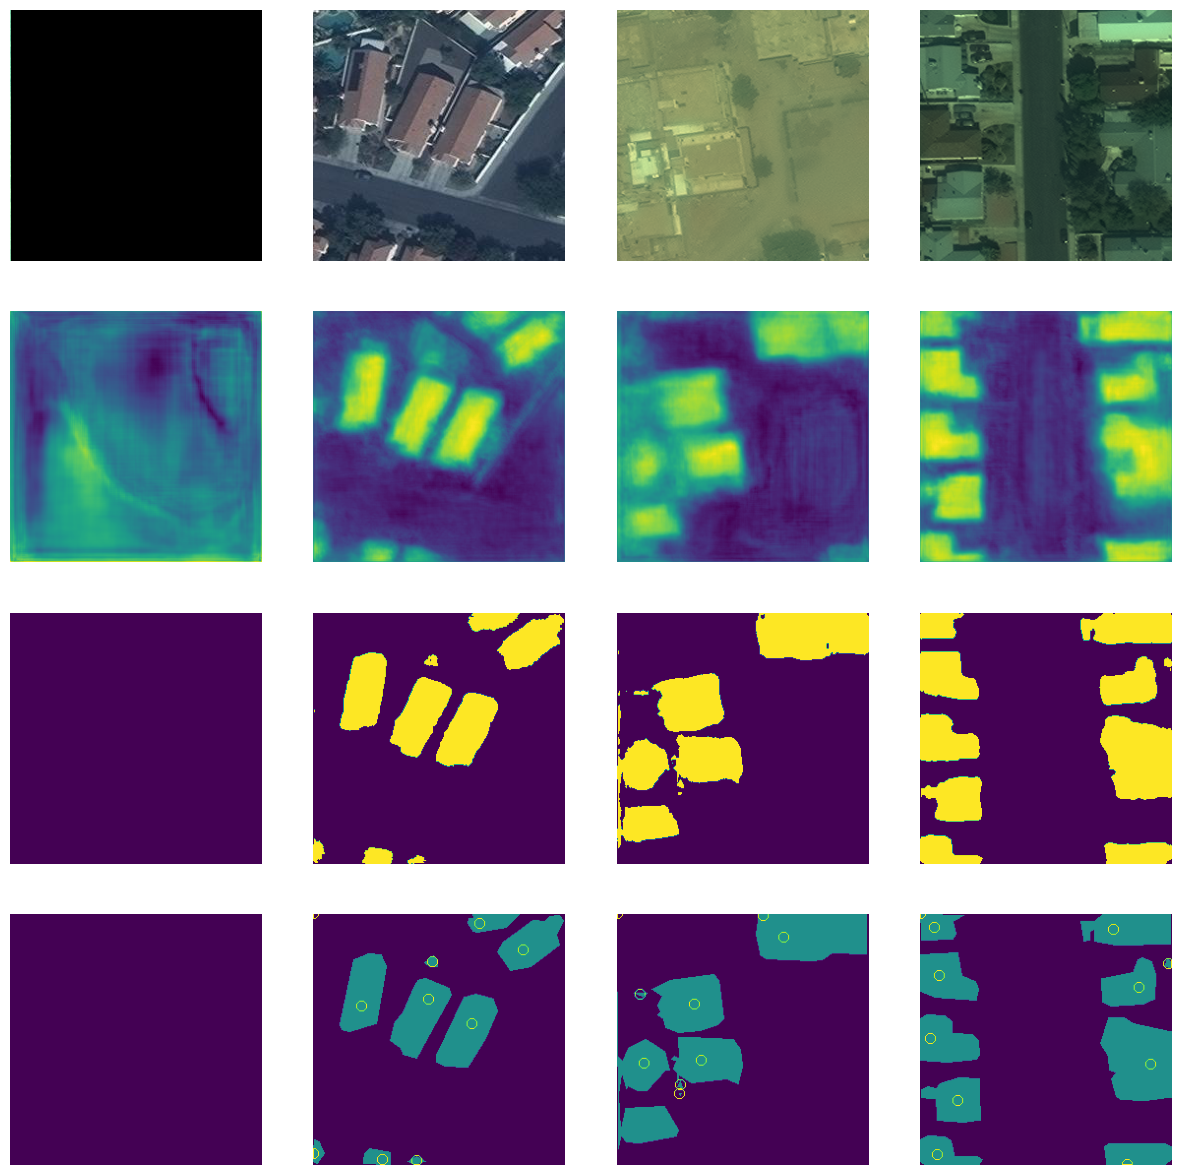

In [173]:
fig, axs = plt.subplots(4, 4, figsize=[15,15])


for i in range(0,4):
    axs[0,i].imshow(x[i,:,:,:].cpu().numpy().transpose(1,2,0))

for i in range(0,4):
    axs[1,i].imshow(y_hat[i,0,:,:].detach().cpu().numpy())

for i in range(0,4):
    axs[2,i].imshow(thresholdOutput[i,0,:,:])

for i in range(0,4):
    axs[3,i].imshow(pred_con[i,:,:], vmax=2)

for i in range(0,4):
    for j in range(0, 4):
        axs[j, i].axis('off')

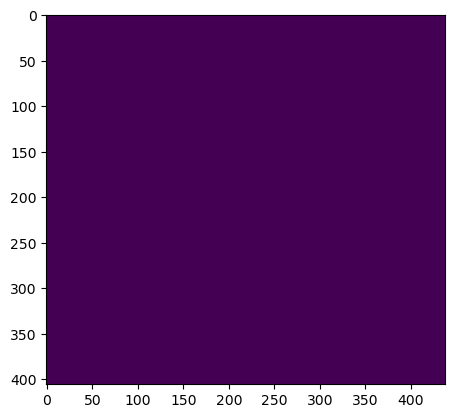

In [3]:
f_a = np.load('final_assem.npy')
plt.imshow(f_a)

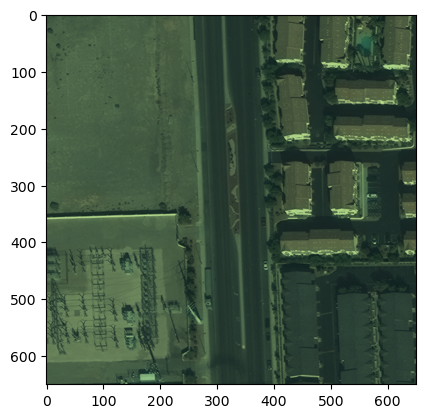

In [22]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import os
path = '/data/spacenet/AOI_2_Vegas/train/3band/RGB-PanSharpen_AOI_2_Vegas_img1006.tif'
path.split('/')[-1]
ras = rio.open(path).read((1,2,3))
ras_8bit = (ras / 2**11) * 2**8
plt.imshow(ras_8bit.transpose(1,2,0).astype(np.uint8))

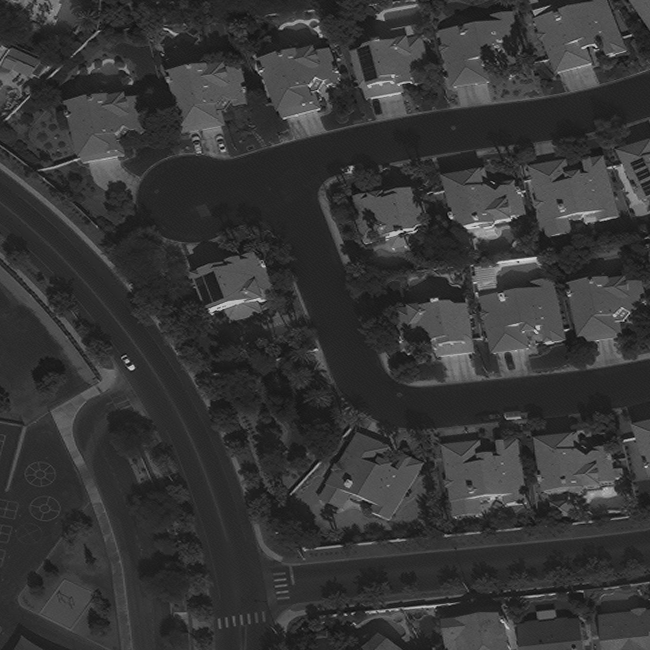

In [31]:
from PIL import Image
ras_img = Image.fromarray(ras_8bit.transpose(1,2,0).astype(np.uint8))
ras_img.convert('L')